## Wikia Webscrape for TKRB Calculator

In [15]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme()

In [16]:
url = 'https://touken-ranbu.fandom.com/wiki/Experience'
res = requests.get(url)

# ensure connection established
assert(res.status_code == 200)

soup = BeautifulSoup(res.content, 'lxml')

In [17]:
def get_table_name(s):
    """
    Finds the sword type a table pertains to.
    
    Inputs:
    s - str - xml table for toudan EXP requirements in string form
    
    Output:
    str - the sword type corresponding to the table
    """
    return re.search(r"""\<th colspan="15"\>(.*?)\n\<\/th\>""", s).group(1)

In [18]:
def get_colnames(s):
    """
    Finds an xml table's column names.
    
    Inputs:
    s - str - xml table for toudan EXP requirements in string form
    
    Output:
    colnames - list - list of unique column name strings found in the table.
    """
    colnames = re.findall(r"\<th\>(.*?)\n\<\/th\>", s)
    seen = set()
    for i, col in enumerate(colnames):
        if col not in seen:
            seen.add(col)
        else:
            return colnames[:i]

In [19]:
def get_meat(colnames, s):
    """
    (In hindsight I should have named this something less suggestive. Whoops.)
    Strips xml tags to cleanly extract data from an xml table given in string format.
    
    Inputs:
    colnames - list of strings - the table's column names
    s - str - xml table in string format
    
    Output:
    result - map - str column names as keys with list of int EXP values.
    """
    result = {}
    # strip tags
    all_data = re.findall(r"\<td\>(.*?)<\/td\>", s.replace("\n", ""))
    n_cols = len(colnames)
    for i in range(len(all_data)):
        col = colnames[i%n_cols]
        data = all_data[i]
        try:
            data = int(data)
        except:
            break
        if col in result:
            result[col].append(data)
        else:
            result[col] = [data]
    return result

In [20]:
def make_table_df(table):
    """
    Oversees the creation of a pandas dataframe given an xml table.
    
    Inputs:
    table - xml - tkrb EXP requirements data table to be converted
    
    Output:
    df - pandas dataframe - the converted table
    """
    table = str(table)
    title = get_table_name(table) # sword type
    cols = get_colnames(table)
    if cols == None: # empty table
        return
    try:
        df = pd.DataFrame(get_meat(cols, table))
        df['Type'] = title
        df = df.sort_values(by = "Lv.") # ascending level order
        df = df.reset_index(drop = True)
        return df
    except:
        return None

In [21]:
all_tabs = []
result = soup.findAll('table', {'class': 'wikitable'})

# create a dataframe for each sword type on the page
for table in result:
    if "Levels 1~99" in str(table):
        all_tabs.append(make_table_df(table))
        
# combine the dataframes
df = pd.concat(all_tabs)

In [22]:
# rename sword types for brevity
df["Type"] = df["Type"].map({
    'Levels 1~99' : 'Regular',
    'Tantou (Kiwame) Levels 1~99' : "Tantouwame",
    'Wakizashi (Kiwame) , Yari (Kiwame) and Naginata (Kiwame) Levels 1~99' : "Waki, Yari, Nagiwame",
    'Uchigatana (Kiwame) R3 Levels 1~99' : "R3 Uchiwame",
    'Uchigatana (Kiwame) R4 Levels 1~99' : "R4 Uchiwame",
    'Tachi (Kiwame) Levels 1~99' : "Tachiwame",
    'Ootachi (Kiwame) Levels 1~99': "Ootachiwame",
})

#### Informal, rough plots to satisfy my curiosity on what the EXP curve looks like

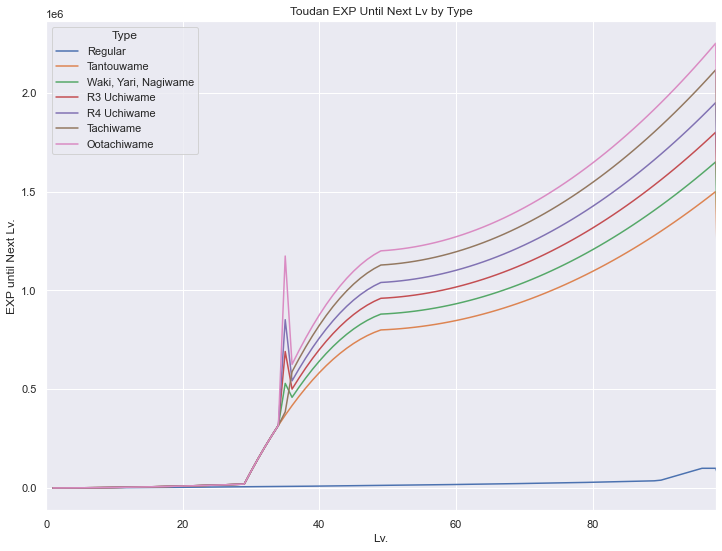

In [23]:
plt.figure(figsize = (12, 9))
sns.lineplot(data = df, x = "Lv.", y = "EXP until Next Lv.",
             hue = "Type")
plt.xlim((0, 98))
plt.title("Toudan EXP Until Next Lv by Type");

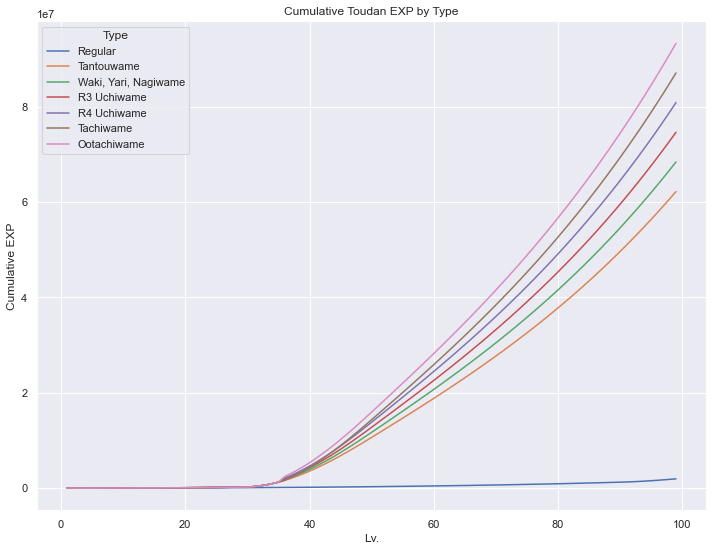

In [24]:
plt.figure(figsize = (12, 9))
sns.lineplot(data = df, x = "Lv.", y = "Cumulative EXP",
             hue = "Type")
plt.title("Cumulative Toudan EXP by Type");

In [34]:
def plot_type(sword_type, l1 = None, l2 = None):
    """
    Facilitates bar plot creation showing EXP requirements for a specific sword type.
    Bar height indicates the EXP requirement to reach the next level, represented as a 
        percentage of the total cumulative EXP needed to reach level 99 (max level).
    
    Inputs:
    sword_type - str - the toudan sword type
    l1 - int - the lower level limit for the plot (horizontal axis)
    l2 - int - the upper level limit for the plot (horizontal axis)
    
    Returns:
    None (outputs seaborn bar plot)
    """
    plt.figure(figsize = (20, 9))
    temp = df[df["Type"] == sword_type].copy()
    final_tot_exp = temp[temp["Lv."] == 99]["Cumulative EXP"]
#     print(final_tot_exp)
    temp["Perc. of Total EXP"] = temp["EXP until Next Lv."].apply(lambda x: x/final_tot_exp * 100)
    sns.barplot(data = temp, x = "Lv.", y = "Perc. of Total EXP", color = "orange")
#     sns.barplot(data = temp, x = "Lv.", y = "EXP until Next Lv.")
#     sns.barplot(data = temp, x = "Lv.", y = "Cumulative EXP", alpha = 0.5)
    if l1 != None and l2 != None:
        plt.xlim((l1, l2))
    plt.title(sword_type + " EXP until Next Level As Perc of Total", size = 20)
    plt.xlabel("Level", size = 16)
    plt.ylabel("Percent of Total EXP at 99", size = 16);
    return

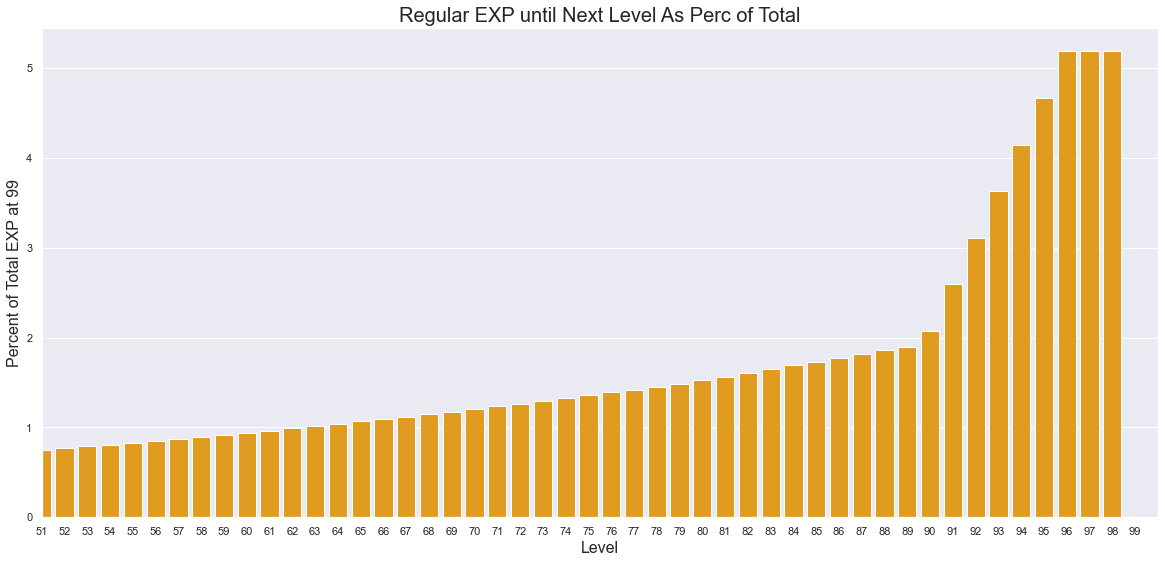

In [35]:
plot_type("Regular", 50, 99)

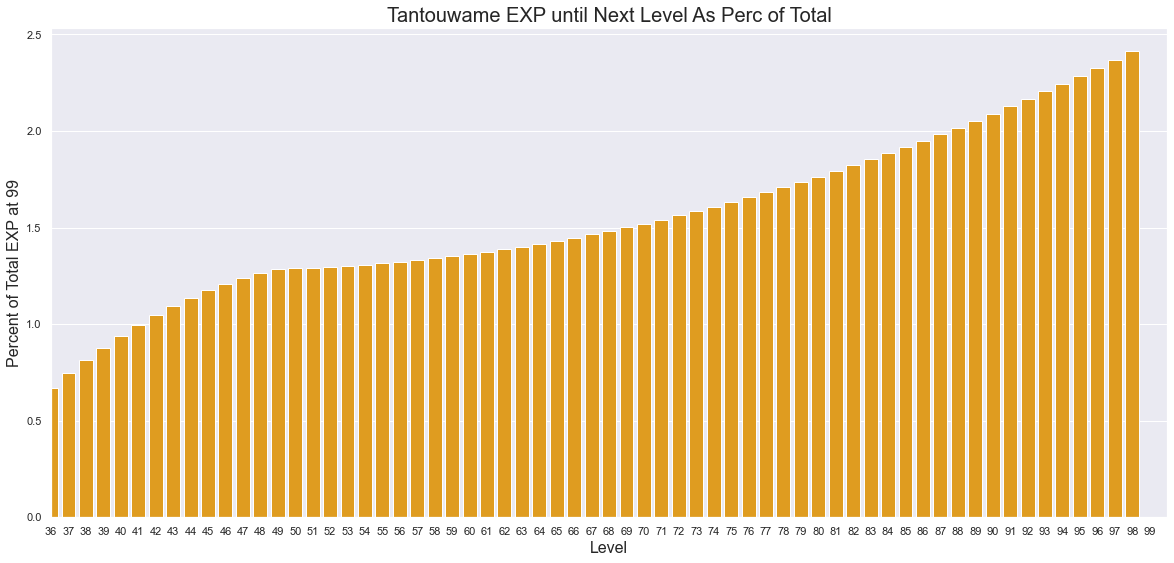

In [36]:
plot_type("Tantouwame", 35, 99)

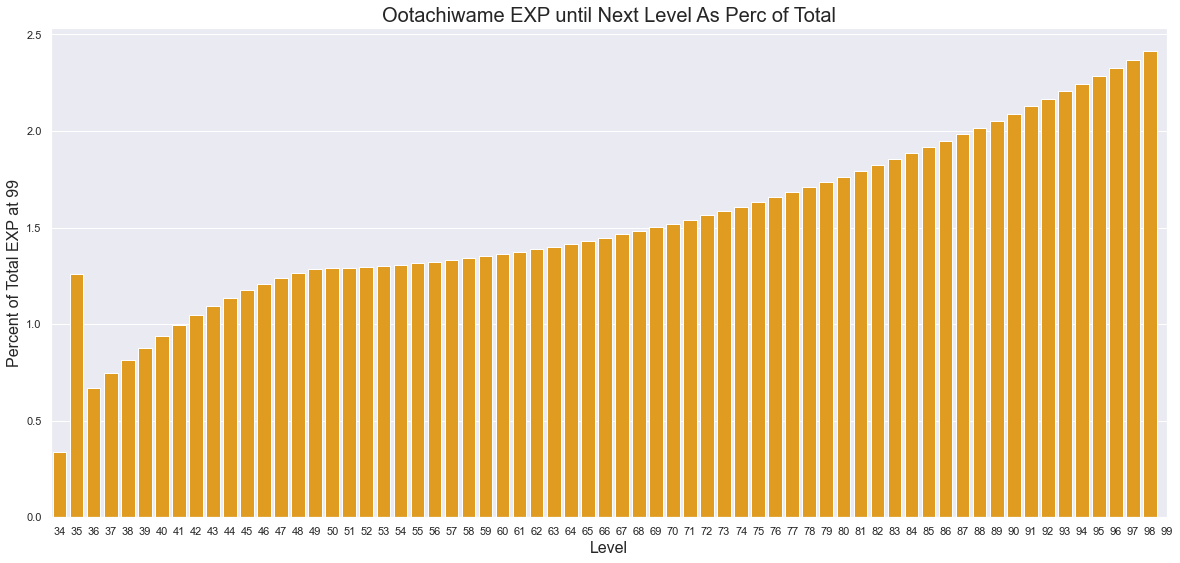

In [37]:
plot_type("Ootachiwame", 32.5, 98)

### Export data

In [28]:
# export pandas dataframe as csv for use in calculator
df.to_csv("./tkrb_exp.csv", index = False)

In [29]:
# check to ensure the csv looks good
pd.read_csv("./tkrb_exp.csv")

,Lv.,Cumulative EXP,EXP until Next Lv.,Type
0,1,0,100,Regular
1,2,100,200,Regular
2,3,300,400,Regular
3,4,700,600,Regular
4,5,1300,800,Regular
...,...,...,...,...
688,95,84516018,2131398,Ootachiwame
689,96,86647416,2170145,Ootachiwame
690,97,88817561,2209678,Ootachiwame
691,98,91027239,2250000,Ootachiwame
